In [ ]:
# based on: https://medium.com/illuin/deep-learning-has-almost-all-the-answers-yes-no-question-answering-with-transformers-223bebb70189

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision
!pip install transformers==2.5.1
!pip install pandas
!pip install numpy

     |████████████████████████████████| 501kB 7.7MB/s 
     |████████████████████████████████| 1.2MB 14.3MB/s 
     |████████████████████████████████| 890kB 36.1MB/s 
     |████████████████████████████████| 5.6MB 51.1MB/s 
     |████████████████████████████████| 133kB 48.5MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 7.4MB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=2becaa69aa63daadb9790f06081e3c8543023dce57d95be8ae30f3b44404a832
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.20.42 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      

# **Imports**

In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# **Model loading**

In [ ]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)


should you change to roberta-large?


# **Data loading**

In [ ]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = pd.read_json("/content/drive/MyDrive/Colab Notebooks/trainmix6500b.jsonl", lines=True, orient='records')
dev_data_df = pd.read_json("/content/drive/MyDrive/Colab Notebooks/devmix6500b.jsonl", lines=True, orient="records")

passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.answer.values.astype(int)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.answer.values.astype(int)

# Encoding data
max_seq_length = 256

input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

take care of this 256/512 max length


In [ ]:
batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

# **Training**

In [ ]:
epochs = 5
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  dev_acc_values.append(epoch_dev_accuracy)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)
Epoch: 100%|██████████| 10/10 [51:33<00:00, 309.40s/it]


# **Results**

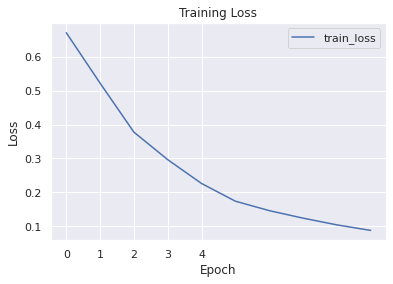

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

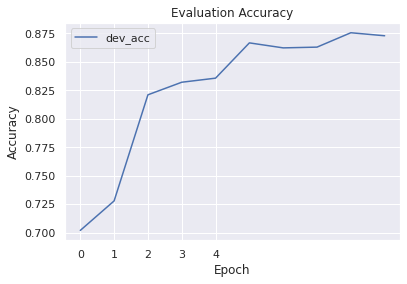

In [ ]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()